## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Forecaster")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 549 (delta 66), reused 56 (delta 25), pack-reused 446
Receiving objects: 100% (549/549), 9.26 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

ModuleNotFoundError: No module named 'google.colab'

## Loading Packages

In [3]:
import os
os.chdir("Src")

In [1]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from eval_inspect import *
import warnings

# warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [33]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False
use_PCA = True

## Preprocessing

In [34]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_only=False, price_only=True)
    target_col = "price_cu_lme"

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


### Visualise the dataset

In [35]:
df_full.head(5)
# df_full.tail(5)
# Visualise the plots if desired
# visualise_df(df_full)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240


### Normalizing the dataset

In [36]:
# Forecast length
forecast_length = 5
# forecast_length = 22
# forecast_length = 66
# forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [38]:
# Reducing the dataset to containing a threshold amount of variance
if use_PCA:
    n_dim = dimension_selector(data_X, thresh=0.95)
    data_X = dimension_reduce(data_X, n_dim)

Number of dimensions: 5
Explained Variance Sum: 0.977
Explained Variance Composition [0.50888011 0.24098335 0.14867818 0.04996657 0.02862028]


### Slicing Series into Windows

In [13]:
# The input size of each time series window
series_length = 132
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (3216, 132, 6) 
Data y shape (3216, 1)


### Hyperparameters

In [19]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 128
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 2
patience = 50
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 2
output_dim = 1
dropout = 0.0

### Initialising the model

In [20]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 8
series_length 132 
batch_size 128
output_dim 1 
num_layers 2
data_X  (3216, 132, 6) 
data_y (3216, 1)


In [21]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

In [6]:
from numpy.random import rand
from torch.optim import Adam
data_X = rand(10, 250, 1)
data_y = rand(10, 1)
device = 'cpu'

model = model_load("Univariate_SS_H8_F22_D5", device, path="Results/Pths/Univariate/Dropout/")
model.device = device
model.to(device)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y,
                        optimiser=Adam(model.parameters()),
                        n_epochs=1,
                        disp_freq=1e6,
                        fig_disp_freq=1e6, 
                        debug=False)

print(learning.MTL)
learning.train_val_test()
# learning.training_wrapper()

False


/anaconda3/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Epoch: 0 Train: 26.28302 Val: 22.03193  Time: 2.553  Best Val: 22.03193


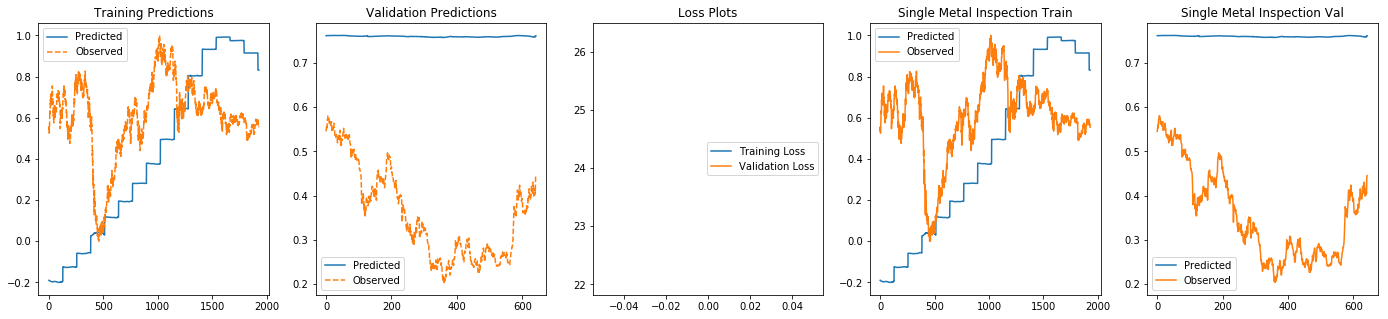

In [22]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X, 
                        scaler_data_y=scaler_data_y)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

### Evaluating the Test Data

In [23]:
learning.evaluate(learning.best_model, learning.test_loader)

1.185416294365936

### Saving Model Objects

In [55]:
model_name = "Multivariate" + "_F" + str(forecast_length) + "_W" + str(series_length) + "_Dense" + str(dense_hidden) 
print(model_name)

# Saving Pickle
pickle.dump(learning, open("Results/Pickles/" + model_name, 'wb'))
# Saving Model Pth
model_save(model, model_name)

Multivariate_F5_W132_Dense32


### Loading Model Objects

#### Must be running on GPU to load pickle

In [ ]:
# Loading Pickle
learning = pickle.load(open("Results/Pickles/" + "Univariate_SS_H4_F5", 'rb'))

In [14]:
# Loading Pth
torch.nn.Module.dump_patches = True
model = model_load("Univariate_SS_H8_F22_D5", device, path="Results/Pths/Univariate/Dropout/")
model_2 = model_load("Univariate_SS_H8_22", device, path="Results/Pths/Univariate/Hidden_Tests/")
model
# model_2


LSTM(
  (lstm): LSTM(1, 8, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [3]:
from numpy.random import rand
from torch.optim import Adam

data_X = rand(500, 250, 1)
data_y = rand(500, 1)

model = model_load("Univariate_SS_H8_F22_D5", device, path="Results/Pths/Univariate/Dropout/")
model.device = device
model.to(device)
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y,
                        optimiser=Adam(model.parameters()))

learning.train_val_test()
learning.create_data_loaders()
learning.evaluate(learning.model, learning.test_loader)

Train Length: 		300
Validation Length: 	100
Test Length:		100

Initial Size Check:

X Train Shape:		 torch.Size([300, 250, 1])
X Val Shape:		 torch.Size([100, 250, 1])
X Test Shape:		 torch.Size([100, 250, 1])

y Train Shape:		 torch.Size([300, 1])
y Val Shape:		 torch.Size([100, 1])
y Test Shape:		 torch.Size([100, 1])


/anaconda3/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


16.6241455078125

### Plotting

In [24]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

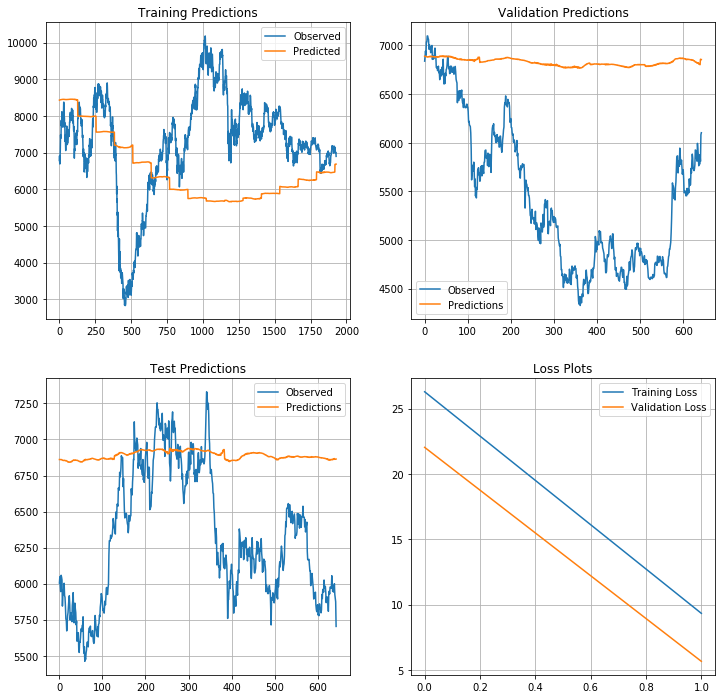

In [25]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

# plt.savefig(path + model_name + ".png")

plt.show()

# Results

In [28]:
mse, mae, mde = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mde)

Price Metrics:  505764.37069345615 599.6188865546941 0.5194401244167963


### Naive Benchmark

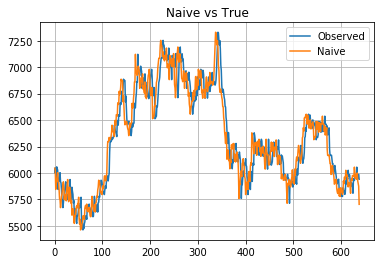

In [29]:
test_naive = test_true[forecast_length:]
plt.plot(test_true[:-forecast_length] ,label="Observed")
plt.plot(test_naive,label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
# plt.savefig("Results/Plots/" + "Naive_F" + str(forecast_length))
plt.show()

### Metrics for benchmarks

In [30]:
# mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[:-forecast_length], log_ret=False)
# print("naive",
#     mse_naive, mae_naive, mde_naive)

# This is for lg return calculations
# mse, mae, mde = evaluate(lg_test_pred, lg_test_true)
# print("Log Returns Metrics: ", 
#       mse, mae, mde)

# The metric for slight inflation
# mse_zeros, mae_zeros, mde_zeros = evaluate(test_zeros, test_true)
# print("Flat",
#     mse_zeros, mae_zeros, mde_zeros)

# mse_increase, mae_increase, mde_increase = evaluate(test_increase, test_true)
# print("Inflation",
#     mse_increase, mae_increase, mde_increase)